In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
from tqdm import tqdm
import math


In [2]:
with open('/home/f20222001/test-venv/UHI/Datasets_processed/inputs_36_extra_clean_10k.pkl', 'rb') as f, open('/home/f20222001/test-venv/UHI/Datasets_processed/targets_36_extra_clean_10k.pkl','rb') as t:
    inputs = pickle.load(f)
    targets = pickle.load(t)
# Shuffle before splitting (preserves alignment of X and y)
X_shuffled, y_shuffled = shuffle(inputs, targets, random_state=42)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.5, random_state=42
)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.25, random_state=42
)

In [3]:
# with open("inputs_small_train_36.pkl", "wb") as f:
#     pickle.dump(X_train, f)

# with open("inputs_small_test_36.pkl", "wb") as f:
#     pickle.dump(X_test, f)
# # Save targets
# with open("targets_small_train_36.pkl", "wb") as f:
#     pickle.dump(y_train, f)
# with open("targets_small_test_36.pkl", "wb") as f:
#     pickle.dump(y_test, f)

In [4]:
# with open("inputs_small_train_36.pkl", "rb") as f:
#     X_train = pickle.load(f)

# with open("inputs_small_test_36.pkl", "rb") as f:
#     X_test = pickle.load(f)
# # Save targets
# with open("targets_small_train_36.pkl", "rb") as f:
#     Y_train = pickle.load(f)
# with open("targets_small_test_36.pkl", "rb") as f:
#     Y_test = pickle.load(f)

In [5]:
# Indexes of features to normalize
norm_idx = [0, 1, 2, 3] 

# Flatten for scaling
X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_val_flat   = X_val.reshape(-1, X_val.shape[2])
X_test_flat  = X_test.reshape(-1, X_test.shape[2])

# Initialize arrays to hold the scaled data
X_train_scaled = X_train_flat.copy()
X_val_scaled   = X_val_flat.copy()
X_test_scaled  = X_test_flat.copy()

scaler = StandardScaler()

# Fit on train, transform all
X_train_scaled[:, norm_idx] = scaler.fit_transform(X_train_flat[:, norm_idx])
X_val_scaled[:, norm_idx]   = scaler.transform(X_val_flat[:, norm_idx])
X_test_scaled[:, norm_idx]  = scaler.transform(X_test_flat[:, norm_idx])

# Reshape back to 3D
X_train = X_train_scaled.reshape(X_train.shape)
X_val   = X_val_scaled.reshape(X_val.shape)
X_test  = X_test_scaled.reshape(X_test.shape)

# Flatten y
y_train_flat = Y_train.reshape(-1, 1)
y_val_flat   = Y_val.reshape(-1, 1)
y_test_flat  = Y_test.reshape(-1, 1)

# Standardize y
standard_scaler_y = StandardScaler()
y_train_scaled = standard_scaler_y.fit_transform(y_train_flat)
y_val_scaled   = standard_scaler_y.transform(y_val_flat)
y_test_scaled  = standard_scaler_y.transform(y_test_flat)

# Reshape back to original shape
Y_train = y_train_scaled.reshape(Y_train.shape)
Y_val   = y_val_scaled.reshape(Y_val.shape)
Y_test  = y_test_scaled.reshape(Y_test.shape)


In [6]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0)]


In [7]:
X_train.shape

(186321, 36, 17)

In [8]:
X_train

array([[[ 1.7408364 , -1.0448433 ,  1.1032712 , ...,  0.        ,
          1.        ,  0.        ],
        [ 1.9447532 , -1.0848677 ,  0.8944518 , ...,  0.        ,
          1.        ,  0.        ],
        [-0.8490643 ,  1.9794558 , -1.5813668 , ...,  0.        ,
          1.        ,  0.        ],
        ...,
        [-0.5423933 ,  0.0293976 ,  0.5611694 , ...,  0.        ,
          1.        ,  0.        ],
        [ 0.44341022, -0.43352407,  0.9187496 , ...,  0.        ,
          1.        ,  0.        ],
        [ 0.7582165 , -0.4953069 ,  1.012027  , ...,  0.        ,
          1.        ,  0.        ]],

       [[ 0.02956364,  0.8856881 , -0.5361191 , ...,  0.        ,
          1.        ,  0.        ],
        [ 0.6075339 ,  0.9626286 , -0.55790365, ...,  0.        ,
          1.        ,  0.        ],
        [ 1.1211277 ,  0.98296636, -0.50631624, ...,  0.        ,
          1.        ,  0.        ],
        ...,
        [ 0.08403571,  0.6891284 , -0.7049615 , ...,  

In [9]:
Y_train.shape

(186321,)

In [10]:
torch.cuda.set_device(2)  

In [11]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(Y_train, dtype=torch.float32))

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(Y_val, dtype=torch.float32))

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(Y_test, dtype=torch.float32))

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [12]:
device = torch.device("cuda")
device

device(type='cuda')

In [13]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout=0.2):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_fc = nn.Linear(d_model, 1)  # regression output

    def forward(self, src):
        # src: (batch_size, seq_len, input_dim)
        src = src.permute(1, 0, 2)  # (seq_len, batch_size, input_dim)
        src = self.input_fc(src)   # (seq_len, batch_size, d_model)
        src = self.pos_encoder(src)
        transformer_out = self.transformer_encoder(src)  # (seq_len, batch_size, d_model)
        out = transformer_out[-1]  # take last time step
        return self.output_fc(out).squeeze(-1)


/home/f20222001/test-venv/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 0.6252984404563904


  1%|          | 1/100 [00:04<06:54,  4.18s/it]

Epoch 2/100 - Train Loss: 0.6313470005989075


  2%|▏         | 2/100 [00:08<06:34,  4.03s/it]

Epoch 3/100 - Train Loss: 0.5499058365821838


  3%|▎         | 3/100 [00:12<06:54,  4.27s/it]

Epoch 4/100 - Train Loss: 0.5561286807060242


  4%|▍         | 4/100 [00:17<07:04,  4.42s/it]

Epoch 5/100 - Train Loss: 0.39709749817848206


  5%|▌         | 5/100 [00:22<07:23,  4.67s/it]

Epoch 6/100 - Train Loss: 0.4308338165283203


  6%|▌         | 6/100 [00:27<07:29,  4.78s/it]

Epoch 7/100 - Train Loss: 0.373005211353302


  7%|▋         | 7/100 [00:32<07:41,  4.96s/it]

Epoch 8/100 - Train Loss: 0.3045855462551117


  8%|▊         | 8/100 [00:37<07:41,  5.02s/it]

Epoch 9/100 - Train Loss: 0.37149813771247864


  9%|▉         | 9/100 [00:43<07:40,  5.06s/it]

Epoch 10/100 - Train Loss: 0.30435675382614136


 10%|█         | 10/100 [00:47<07:31,  5.01s/it]

Epoch 11/100 - Train Loss: 0.3086327016353607


 11%|█         | 11/100 [00:53<07:35,  5.12s/it]

Epoch 12/100 - Train Loss: 0.3766307532787323


 12%|█▏        | 12/100 [00:58<07:29,  5.11s/it]

Epoch 13/100 - Train Loss: 0.26110222935676575


 13%|█▎        | 13/100 [01:03<07:24,  5.10s/it]

Epoch 14/100 - Train Loss: 0.23492050170898438


 14%|█▍        | 14/100 [01:08<07:25,  5.19s/it]

Epoch 15/100 - Train Loss: 0.2208753079175949


 15%|█▌        | 15/100 [01:13<07:10,  5.07s/it]

Epoch 16/100 - Train Loss: 0.29644137620925903


 16%|█▌        | 16/100 [01:18<06:58,  4.99s/it]

Epoch 17/100 - Train Loss: 0.2952621281147003


 17%|█▋        | 17/100 [01:23<06:48,  4.92s/it]

Epoch 18/100 - Train Loss: 0.2607176899909973


 18%|█▊        | 18/100 [01:28<06:51,  5.02s/it]

Epoch 19/100 - Train Loss: 0.29552555084228516


 19%|█▉        | 19/100 [01:33<06:42,  4.97s/it]

Epoch 20/100 - Train Loss: 0.2870439291000366


 20%|██        | 20/100 [01:38<06:35,  4.94s/it]

Epoch 21/100 - Train Loss: 0.2677057683467865


 21%|██        | 21/100 [01:43<06:28,  4.91s/it]

Epoch 22/100 - Train Loss: 0.24898892641067505


 22%|██▏       | 22/100 [01:47<06:14,  4.81s/it]

Epoch 23/100 - Train Loss: 0.2055709958076477


 23%|██▎       | 23/100 [01:51<05:57,  4.64s/it]

Epoch 24/100 - Train Loss: 0.2250964343547821


 24%|██▍       | 24/100 [01:56<05:54,  4.67s/it]

Epoch 25/100 - Train Loss: 0.2292691469192505


 25%|██▌       | 25/100 [02:01<05:53,  4.71s/it]

Epoch 26/100 - Train Loss: 0.26380985975265503


 26%|██▌       | 26/100 [02:05<05:38,  4.58s/it]

Epoch 27/100 - Train Loss: 0.22190141677856445


 27%|██▋       | 27/100 [02:10<05:33,  4.57s/it]

Epoch 28/100 - Train Loss: 0.18167448043823242


 28%|██▊       | 28/100 [02:15<05:34,  4.65s/it]

Epoch 29/100 - Train Loss: 0.17341049015522003


 29%|██▉       | 29/100 [02:20<05:45,  4.87s/it]

Epoch 30/100 - Train Loss: 0.2294231802225113


 30%|███       | 30/100 [02:25<05:37,  4.82s/it]

Epoch 31/100 - Train Loss: 0.25929081439971924


 31%|███       | 31/100 [02:29<05:30,  4.78s/it]

Epoch 32/100 - Train Loss: 0.2240009307861328


 32%|███▏      | 32/100 [02:34<05:26,  4.81s/it]

Epoch 33/100 - Train Loss: 0.18017268180847168


 33%|███▎      | 33/100 [02:40<05:34,  4.99s/it]

Epoch 34/100 - Train Loss: 0.22993336617946625


 34%|███▍      | 34/100 [02:44<05:26,  4.95s/it]

Epoch 35/100 - Train Loss: 0.20774221420288086


 35%|███▌      | 35/100 [02:49<05:19,  4.92s/it]

Epoch 36/100 - Train Loss: 0.20565932989120483


 36%|███▌      | 36/100 [02:54<05:13,  4.90s/it]

Epoch 37/100 - Train Loss: 0.17613746225833893


 37%|███▋      | 37/100 [02:59<05:05,  4.86s/it]

Epoch 38/100 - Train Loss: 0.18363982439041138


 38%|███▊      | 38/100 [03:04<04:56,  4.78s/it]

Epoch 39/100 - Train Loss: 0.15351513028144836


 39%|███▉      | 39/100 [03:09<04:55,  4.85s/it]

Epoch 40/100 - Train Loss: 0.19422823190689087


 40%|████      | 40/100 [03:14<04:57,  4.96s/it]

Epoch 41/100 - Train Loss: 0.18514584004878998


 41%|████      | 41/100 [03:19<04:52,  4.96s/it]

Epoch 42/100 - Train Loss: 0.1963501274585724


 42%|████▏     | 42/100 [03:24<04:46,  4.94s/it]

Epoch 43/100 - Train Loss: 0.17512880265712738


 43%|████▎     | 43/100 [03:29<04:44,  4.98s/it]

Epoch 44/100 - Train Loss: 0.1666761338710785


 44%|████▍     | 44/100 [03:33<04:35,  4.91s/it]

Epoch 45/100 - Train Loss: 0.15245269238948822


 45%|████▌     | 45/100 [03:37<04:10,  4.56s/it]

Epoch 46/100 - Train Loss: 0.17520904541015625


 46%|████▌     | 46/100 [03:41<03:50,  4.26s/it]

Epoch 47/100 - Train Loss: 0.2017313539981842


 47%|████▋     | 47/100 [03:44<03:29,  3.96s/it]

Epoch 48/100 - Train Loss: 0.15227162837982178


 48%|████▊     | 48/100 [03:47<03:13,  3.71s/it]

Epoch 49/100 - Train Loss: 0.13602080941200256


 49%|████▉     | 49/100 [03:50<03:01,  3.56s/it]

Epoch 50/100 - Train Loss: 0.14355331659317017


 50%|█████     | 50/100 [03:53<02:50,  3.42s/it]

Epoch 51/100 - Train Loss: 0.18236030638217926


 51%|█████     | 51/100 [03:57<02:44,  3.37s/it]

Epoch 52/100 - Train Loss: 0.16980710625648499


 52%|█████▏    | 52/100 [04:00<02:37,  3.28s/it]

Epoch 53/100 - Train Loss: 0.17670480906963348


 53%|█████▎    | 53/100 [04:03<02:31,  3.23s/it]

Epoch 54/100 - Train Loss: 0.15492141246795654


 54%|█████▍    | 54/100 [04:06<02:28,  3.22s/it]

Epoch 55/100 - Train Loss: 0.16829539835453033


 55%|█████▌    | 55/100 [04:09<02:26,  3.25s/it]

Epoch 56/100 - Train Loss: 0.13165612518787384


 56%|█████▌    | 56/100 [04:13<02:22,  3.23s/it]

Epoch 57/100 - Train Loss: 0.17544078826904297


 57%|█████▋    | 57/100 [04:16<02:27,  3.44s/it]

Epoch 58/100 - Train Loss: 0.10925357043743134


 58%|█████▊    | 58/100 [04:21<02:43,  3.88s/it]

Epoch 59/100 - Train Loss: 0.1328611820936203


 59%|█████▉    | 59/100 [04:26<02:49,  4.13s/it]

Epoch 60/100 - Train Loss: 0.1294475495815277


 60%|██████    | 60/100 [04:31<02:54,  4.36s/it]

Epoch 61/100 - Train Loss: 0.12824784219264984


 61%|██████    | 61/100 [04:36<02:52,  4.43s/it]

Epoch 62/100 - Train Loss: 0.13738560676574707


 62%|██████▏   | 62/100 [04:41<02:56,  4.64s/it]

Epoch 63/100 - Train Loss: 0.13273312151432037


 63%|██████▎   | 63/100 [04:46<02:56,  4.77s/it]

Epoch 64/100 - Train Loss: 0.11599649488925934


 64%|██████▍   | 64/100 [04:51<02:52,  4.80s/it]

Epoch 65/100 - Train Loss: 0.12921898066997528


 65%|██████▌   | 65/100 [04:55<02:46,  4.76s/it]

Epoch 66/100 - Train Loss: 0.11457233130931854


 66%|██████▌   | 66/100 [05:00<02:42,  4.79s/it]

Epoch 67/100 - Train Loss: 0.10482349246740341


 67%|██████▋   | 67/100 [05:05<02:39,  4.83s/it]

Epoch 68/100 - Train Loss: 0.11524638533592224


 68%|██████▊   | 68/100 [05:10<02:35,  4.85s/it]

Epoch 69/100 - Train Loss: 0.14331813156604767


 69%|██████▉   | 69/100 [05:15<02:32,  4.93s/it]

Epoch 70/100 - Train Loss: 0.11392053961753845


 70%|███████   | 70/100 [05:20<02:26,  4.89s/it]

Epoch 71/100 - Train Loss: 0.15314854681491852


 71%|███████   | 71/100 [05:24<02:16,  4.72s/it]

Epoch 72/100 - Train Loss: 0.12115359306335449


 72%|███████▏  | 72/100 [05:29<02:09,  4.62s/it]

Epoch 73/100 - Train Loss: 0.1297246515750885


 73%|███████▎  | 73/100 [05:33<02:05,  4.64s/it]

Epoch 74/100 - Train Loss: 0.12641501426696777


 74%|███████▍  | 74/100 [05:38<02:01,  4.67s/it]

Epoch 75/100 - Train Loss: 0.14532482624053955


 75%|███████▌  | 75/100 [05:43<01:56,  4.67s/it]

Epoch 76/100 - Train Loss: 0.0894828587770462


 76%|███████▌  | 76/100 [05:48<01:52,  4.69s/it]

Epoch 77/100 - Train Loss: 0.11730600893497467


 77%|███████▋  | 77/100 [05:52<01:49,  4.76s/it]

Epoch 78/100 - Train Loss: 0.1315155178308487


 78%|███████▊  | 78/100 [05:57<01:44,  4.76s/it]

Epoch 79/100 - Train Loss: 0.12054426223039627


 79%|███████▉  | 79/100 [06:02<01:39,  4.75s/it]

Epoch 80/100 - Train Loss: 0.12515974044799805


 80%|████████  | 80/100 [06:07<01:37,  4.88s/it]

Epoch 81/100 - Train Loss: 0.11209840327501297


 81%|████████  | 81/100 [06:12<01:33,  4.93s/it]

Epoch 82/100 - Train Loss: 0.12938754260540009


 82%|████████▏ | 82/100 [06:17<01:28,  4.93s/it]

Epoch 83/100 - Train Loss: 0.12829206883907318


 83%|████████▎ | 83/100 [06:22<01:23,  4.91s/it]

Epoch 84/100 - Train Loss: 0.08842264860868454


 84%|████████▍ | 84/100 [06:27<01:19,  4.99s/it]

Epoch 85/100 - Train Loss: 0.10080668330192566


 85%|████████▌ | 85/100 [06:32<01:14,  4.96s/it]

Epoch 86/100 - Train Loss: 0.08842558413743973


 86%|████████▌ | 86/100 [06:37<01:09,  4.99s/it]

Epoch 87/100 - Train Loss: 0.12562666833400726


 87%|████████▋ | 87/100 [06:42<01:04,  4.99s/it]

Epoch 88/100 - Train Loss: 0.09667561203241348


 88%|████████▊ | 88/100 [06:47<01:00,  5.04s/it]

Epoch 89/100 - Train Loss: 0.11184326559305191


 89%|████████▉ | 89/100 [06:52<00:55,  5.03s/it]

Epoch 90/100 - Train Loss: 0.09857816249132156


 90%|█████████ | 90/100 [06:57<00:50,  5.05s/it]

Epoch 91/100 - Train Loss: 0.1177680492401123


 91%|█████████ | 91/100 [07:03<00:46,  5.18s/it]

Epoch 92/100 - Train Loss: 0.10927404463291168


 92%|█████████▏| 92/100 [07:08<00:40,  5.09s/it]

Epoch 93/100 - Train Loss: 0.12387578934431076


 93%|█████████▎| 93/100 [07:13<00:35,  5.03s/it]

Epoch 94/100 - Train Loss: 0.09876953065395355


 94%|█████████▍| 94/100 [07:18<00:30,  5.02s/it]

Epoch 95/100 - Train Loss: 0.09123434126377106


 95%|█████████▌| 95/100 [07:23<00:25,  5.04s/it]

Epoch 96/100 - Train Loss: 0.09374421834945679


 96%|█████████▌| 96/100 [07:26<00:18,  4.67s/it]

Epoch 97/100 - Train Loss: 0.10287733376026154


 97%|█████████▋| 97/100 [07:31<00:13,  4.48s/it]

Epoch 98/100 - Train Loss: 0.1064855307340622


 98%|█████████▊| 98/100 [07:34<00:08,  4.33s/it]

Epoch 99/100 - Train Loss: 0.11442965269088745


 99%|█████████▉| 99/100 [07:39<00:04,  4.48s/it]

Epoch 100/100 - Train Loss: 0.1424170434474945


100%|██████████| 100/100 [07:44<00:00,  4.64s/it]


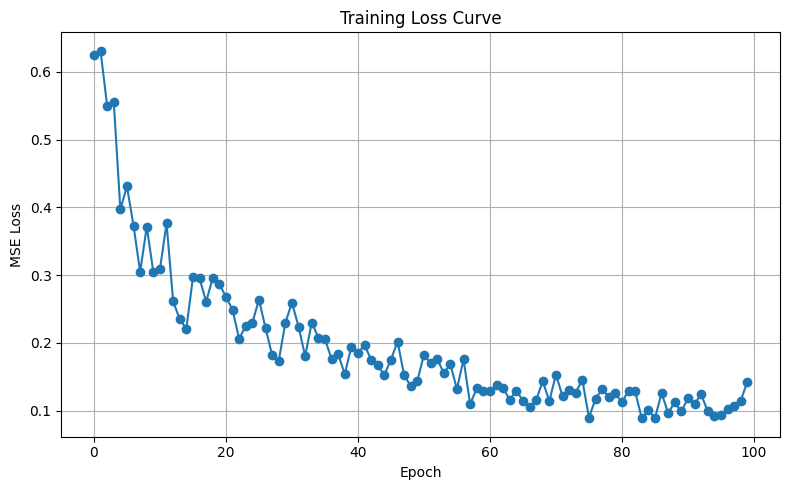

In [14]:
input_size = X_train.shape[2]  # num_features per timestep
model = TransformerRegressor(input_dim=input_size)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Training loop
num_epochs = 100
train_losses = []
val_losses = {
    "mse": [],
    "rmse": [],
    "mae": [],
    "r2": []
}

for epoch in tqdm(range(num_epochs)):
    model.train()

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        #print(batch_x.shape)
        #print(batch_y.shape)
        # Forward
        preds = model(batch_x)  # shape: (batch_size,)
        #print(preds.shape)
        loss = criterion(preds, batch_y)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {loss.item()}")
    train_losses.append(loss.item())

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x = val_x.to(device)
            val_y = val_y.to(device)

            preds = model(val_x)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(val_y.cpu().numpy())

    # Concatenate and inverse scale
    all_preds_np = np.concatenate(all_preds).reshape(-1, 1)
    all_targets_np = np.concatenate(all_targets).reshape(-1, 1)

    y_pred = standard_scaler_y.inverse_transform(all_preds_np)
    y_true = standard_scaler_y.inverse_transform(all_targets_np)

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    val_losses["mse"].append(mse)
    val_losses["rmse"].append(rmse)
    val_losses["mae"].append(mae)
    val_losses["r2"].append(r2)


plt.figure(figsize=(8, 5))
plt.plot(np.arange(num_epochs),train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        preds = model(batch_x)
        
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true).reshape(-1, 1)
y_pred = np.array(y_pred).reshape(-1, 1)

# Unnormalize using RobustScaler
y_true = standard_scaler_y.inverse_transform(y_true)
y_pred = standard_scaler_y.inverse_transform(y_pred)

# Flatten back
y_true = y_true.flatten()
y_pred = y_pred.flatten()

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape=mean_absolute_percentage_error(y_true, y_pred)
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test R²:   {r2:.4f}")
print(f"Test MAPE:   {mape:.4f}")

Test MSE:  7.0941
Test RMSE: 2.6635
Test MAE:  1.6514
Test R²:   0.9090
Test MAPE:   0.0626


In [16]:
val_losses['mae']

[5.652235984802246,
 5.454874515533447,
 4.6171393394470215,
 4.253900527954102,
 3.9531967639923096,
 3.7097342014312744,
 3.520326614379883,
 3.647243022918701,
 3.624467372894287,
 3.3533260822296143,
 3.087207317352295,
 3.1651883125305176,
 3.1686923503875732,
 3.079204797744751,
 2.9852676391601562,
 3.1015031337738037,
 3.1657660007476807,
 2.82053542137146,
 2.833143949508667,
 2.917310953140259,
 2.7228376865386963,
 2.798588275909424,
 2.9302897453308105,
 2.705652952194214,
 2.7381432056427,
 2.555593252182007,
 2.514005661010742,
 2.6709070205688477,
 2.4649651050567627,
 2.478166341781616,
 2.419370651245117,
 2.4254586696624756,
 2.3147332668304443,
 2.3370227813720703,
 2.463580846786499,
 2.439187526702881,
 2.3759913444519043,
 2.3649179935455322,
 2.278710126876831,
 2.3192853927612305,
 2.1928369998931885,
 2.2544913291931152,
 2.2148358821868896,
 2.234445095062256,
 2.2720401287078857,
 2.1335530281066895,
 2.202758312225342,
 2.138814687728882,
 2.1059534549713135